In [1]:
import numpy as np
import random as rand
#import network_equ_xy_energy 
#import network_gen_isotropic 
import openpyxl 
import collections
import timeit
import glob
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import math
from scipy.optimize import fsolve, root
import scipy.optimize as optimize

In [2]:

title_font = {'fontname':'Arial', 'size':'15', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'13'}


In [3]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.tri import Triangulation, TriAnalyzer, UniformTriRefiner
import matplotlib as mpl

# Check Ogden 

The Ogden model fits the data really well, similar to the NN without convexity constraint. 
This implies either (or both): 
* The convexity constraint is being applied incorrectly: yes, this is true, Yue found that the first index from K.gradients() is the index of the batch and not the index corresponding to the variable from which we want the gradient. 
* The convexity constraint is not correct: yes, this is also true actually. As seen below, the Ogden model is in terms of the principal strains. But one can fit a GP to the strain energy as function of the invariants I1 and I2. Doing so, we can check if the Psi_ogden(I1,I2) is convex with respect to I1 and I2. IT IS NOT. the determinant of the Hessian is not positive. Why? Because the requirement is convexity of Psi with respect to C. I1 and I2 are convex functions of C, and Psi_Ogden(I1,I2) is a convex function of C, BUT, f(I1,I2) is not a convex function of I1, I2. I am not sure about the converse, if you are convex with respect to I1 and I2, do you guarantee convexity with respect to C? In other words, if Psi(I1,I2) is a convex function of I1 and I2, is it a convex function of C? I don't know.  

The correct check for convexity with respect to C is to either do 
* Monotonicity test of PK2 (without the energy) 
* Inequality from 'line' connecting two deformations (like a Taylor expansion for energy, the true energy is greater or equal than connecting a line from deformation i to deformation j) 

So first here I check that even though Psi_ogden(I1,I2) is not convex with respect to I1,I2, it is convex with respect to C. 

In [222]:
## Check Ogden model convexity constraints 
## check if Ogden interpolated with plane stress gives us a convex potential 
def eval_Psi_ogden(mu,alpha,lamx,lamy,lamz):
    return mu/alpha*(lamx**alpha+lamy**alpha+lamz**alpha-3)

def eval_sigma_Ogden(mu, alpha,lamx,lamy):
    lamz = 1./(lamx*lamy)
    p = mu*lamz**alpha
    sigmax = -p+mu*lamx**alpha
    sigmay = -p+mu*lamy**alpha
    return sigmax,sigmay


In [223]:
# Get the energy from Ogden, as well as stress, for bunch of equibiaxial deformations 
lamx_ls = np.linspace(1,1.25,11)
lamy_ls = np.linspace(1,1.25,11)
I1_vec = np.zeros((11**2))
I2_vec = np.zeros((11**2))
X = np.zeros((11**2,2))
Psi_vec = np.zeros((11**2,1))
sigma_vec = np.zeros((11**2,2))
PK2_vec = np.zeros((11**2,2))
C_vec  = np.zeros((11**2,2))
mu = 0.4985708
alpha = 8.52112645
for i in range(11):
    for j in range(11):
        lamx = lamx_ls[i]
        lamy = lamy_ls[j]
        lamz = (1./(lamx*lamy))
        I1 = lamx**2+lamy**2+lamz**2
        I2 = lamx**2 * lamy**2 + lamx**2 * lamz**2 + lamy**2 * lamz**2
        psi = eval_Psi_ogden(mu,alpha,lamx,lamy,lamz)
        I1_vec[i*11+j] = I1
        I2_vec[i*11+j] = I2
        X[i*11+j,0] = I1
        X[i*11+j,1] = I2
        Psi_vec[i*11+j] = psi
        sigmax,sigmay=eval_sigma_Ogden(mu, alpha,lamx,lamy)
        sigma_vec[i*11+j,0] =sigmax
        sigma_vec[i*11+j,1] =sigmay
        sigma = np.array([[sigmax,0],[0,sigmay]])
        F = np.array([[lamx,0],[0,lamy]])
        Finv = np.linalg.inv(F)
        PK2 = np.dot(Finv,np.dot(sigma,Finv.transpose()))
        PK2_vec[i*11+j,0] = PK2[0,0]
        PK2_vec[i*11+j,1] = PK2[1,1]
        C_vec[i*11+j,0] = lamx**2
        C_vec[i*11+j,1] = lamy**2

In [226]:
## Check convexity between any pair of biaxial deformations 
convexity_checks = np.zeros((121*121))
ct=0
neg_ct = 0
pos_ct = 0
z_ct = 0
for i in range(121):
    for j in range(0,121): 
        # Taylor expansion 
        # Psi_j = Psi_i + dSdC_i:(C_j - C_i)
        check = Psi_vec[j]- Psi_vec[i] - 0.5*np.dot(PK2_vec[i],C_vec[j]-C_vec[i])
        convexity_checks[ct] = check
        if check<0:
            neg_ct+=1
        elif check>0:
            pos_ct+=1
        elif check==0:
            z_ct+=1
#         if check<0:
#             print('Not satisfied: ')
#             print('C_i')
#             print(C_vec[i])
#             print('C_j')
#             print(C_vec[j])
#             print('Psi_i')
#             print(Psi_vec[i])
#             print('Psi_j')
#             print(Psi_vec[j])
#             print('PK2_i')
#             print(PK2_vec[i])
        ct+=1

(array([6.089e+03, 3.652e+03, 2.346e+03, 1.426e+03, 6.870e+02, 2.990e+02,
        9.600e+01, 3.100e+01, 1.300e+01, 2.000e+00]),
 array([0.        , 0.06092812, 0.12185624, 0.18278437, 0.24371249,
        0.30464061, 0.36556873, 0.42649686, 0.48742498, 0.5483531 ,
        0.60928122]),
 <a list of 10 Patch objects>)

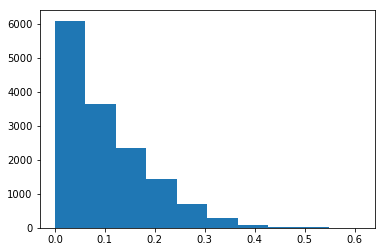

In [227]:
plt.hist(convexity_checks)

In [27]:
print(pos_ct)
print(neg_ct)
print(z_ct)

7260
0
0


In [228]:
# different argument is that from the paper 
# On the convexity of nonlinear elastic energies in the right Cauchy-Green tensor
convexity_checks = np.zeros((121*61))
ct=0
neg_ct = 0
pos_ct = 0
z_ct = 0
for i in range(121):
    for j in range(i+1,121): 
        # Taylor expansion 
        # Psi_j = Psi_i + dSdC_i:(C_j - C_i)
        check = np.dot(PK2_vec[j]-PK2_vec[i],C_vec[j]-C_vec[i])
        convexity_checks[ct] = check
        if check<0:
            neg_ct+=1
        elif check>0:
            pos_ct+=1
        elif check==0:
            z_ct+=1
        ct+=1


(array([3.071e+03, 1.813e+03, 1.154e+03, 7.340e+02, 3.870e+02, 1.380e+02,
        5.600e+01, 2.300e+01, 4.000e+00, 1.000e+00]),
 array([0.        , 0.23954797, 0.47909595, 0.71864392, 0.95819189,
        1.19773987, 1.43728784, 1.67683581, 1.91638379, 2.15593176,
        2.39547973]),
 <a list of 10 Patch objects>)

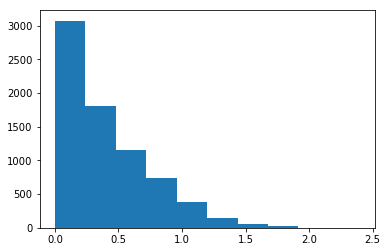

In [229]:
plt.hist(convexity_checks)

In [24]:
print(pos_ct)
print(neg_ct)
print(z_ct)

7260
0
0


In [ ]:
# check Ogden convexity on equibiaxial

In [28]:
def eval_Psi_ogden(mu,alpha,lamx,lamy,lamz):
    return mu/alpha*(lamx**alpha+lamy**alpha+lamz**alpha-3)

In [29]:
import GPy

In [30]:
lamx_ls = np.linspace(1,1.25,11)
lamy_ls = np.linspace(1,1.25,11)
I1_vec = np.zeros((11**2))
I2_vec = np.zeros((11**2))
X = np.zeros((11**2,2))
Psi_vec = np.zeros((11**2,1))
mu = 0.4985708
alpha = 8.52112645
for i in range(11):
    for j in range(11):
        lamx = lamx_ls[i]
        lamy = lamy_ls[j]
        lamz = (1./(lamx*lamy))
        I1 = lamx**2+lamy**2+lamz**2
        I2 = lamx**2 * lamy**2 + lamx**2 * lamz**2 + lamy**2 * lamz**2
        psi = eval_Psi_ogden(mu,alpha,lamx,lamy,lamz)
        I1_vec[i*11+j] = I1
        I2_vec[i*11+j] = I2
        X[i*11+j,0] = I1
        X[i*11+j,1] = I2
        Psi_vec[i*11+j] = psi

In [31]:

X_mean = np.mean(X, axis=0)
#X_mean = np.zeros((2))
X_std = np.std(X, axis=0)
#X_std = np.ones((2))

X_scaled = (X - X_mean) / X_std
# and regress between X_s and Z_NH
k1 = GPy.kern.RBF(input_dim=2, ARD=True)
try:
    model_O = GPy.models.GPRegression(X_scaled, Psi_vec, k1)
    model_O.optimize()
    Psi, var = model_O.predict(X_scaled)
    #prediction of the gradient of the GP
    #ad_Psi, dvar = model_NH.predictive_gradients((Xp - X_m) / X_s)
    grad_Psi, dvar = model_O.predict_jacobian(X_scaled)
    dPsidI1 = grad_Psi[:,0,0]/X_std[0]
    dPsidI2 = grad_Psi[:,1,0]/X_std[1]
except np.linalg.LinAlgError:
    print('WARNING: numpy.linalg.LinAlgError: not positive definite, even with jitter.')
    pass

In [32]:
n_eb = 25
lam_eq_ls = np.linspace(1,1.25,n_eb)
I1_eb = np.zeros((n_eb))
I2_eb = np.zeros((n_eb))
# checking convexity of Ogden 
Psi1_ogden_equi = np.zeros((n_eb))
Psi2_ogden_equi = np.zeros((n_eb))
Psi_ogden_equi = np.zeros((n_eb))
X_equi = np.zeros((n_eb,2))
for i in range(n_eb):
    lamx = lam_eq_ls[i]
    lamy = lam_eq_ls[i]
    lamz = 1./(lamx*lamy)
    I1 = lamx**2+lamy**2+lamz**2
    I2 = lamx**2 * lamy**2 + lamx**2 * lamz**2 + lamy**2 * lamz**2
    psi = eval_Psi_ogden(mu,alpha,lamx,lamy,lamz)
    I1_eb[i] = I1
    I2_eb[i] = I2
    Psi_ogden_equi[i] = psi 
    X_equi[i,0]  = I1
    X_equi[i,1]  = I2

X_equi_scaled = (X_equi - X_mean) / X_std
grad_Psi, dvar = model_O.predict_jacobian(X_equi_scaled)
dPsidI1_equi_ogden = grad_Psi[:,0,0]/X_std[0]
dPsidI2_equi_ogden = grad_Psi[:,1,0]/X_std[1]

eps = 1e-5

X_equi_p1 = np.zeros((n_eb,2))
X_equi_p1[:,0] = X_equi[:,0] + eps
X_equi_p1[:,1] = X_equi[:,1]
X_equi_scaled_p1 = (X_equi_p1 - X_mean) / X_std
grad_Psi_p1, dvar = model_O.predict_jacobian(X_equi_scaled_p1)
dPsidI1_equi_ogden_p1 = grad_Psi_p1[:,0,0]/X_std[0]
dPsidI2_equi_ogden_p1 = grad_Psi_p1[:,1,0]/X_std[1]
X_equi_p2 = np.zeros((n_eb,2))
X_equi_p2[:,0] = X_equi[:,0] 
X_equi_p2[:,1] = X_equi[:,1]+ eps
X_equi_scaled_p2 = (X_equi_p2 - X_mean) / X_std
grad_Psi_p2, dvar = model_O.predict_jacobian(X_equi_scaled_p2)
dPsidI1_equi_ogden_p2 = grad_Psi_p2[:,0,0]/X_std[0]
dPsidI2_equi_ogden_p2 = grad_Psi_p2[:,1,0]/X_std[1]
dPsidI1dI1 = (dPsidI1_equi_ogden_p1-dPsidI1_equi_ogden)/eps
dPsidI1dI2 = (dPsidI1_equi_ogden_p2-dPsidI1_equi_ogden)/eps
dPsidI2dI1 = (dPsidI2_equi_ogden_p1-dPsidI2_equi_ogden)/eps
dPsidI2dI2 = (dPsidI2_equi_ogden_p2-dPsidI2_equi_ogden)/eps

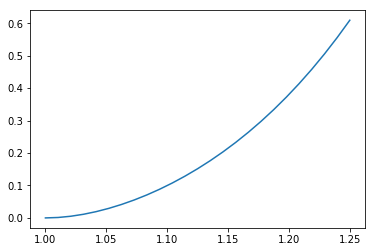

In [33]:
plt.plot(lam_eq_ls,Psi_ogden_equi)

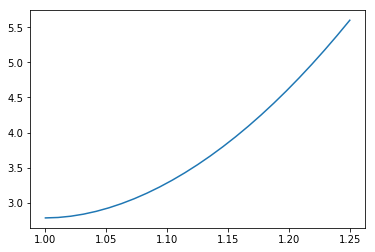

In [34]:
plt.plot(lam_eq_ls,dPsidI1_equi_ogden)

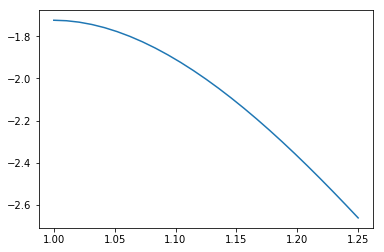

In [35]:
plt.plot(lam_eq_ls,dPsidI2_equi_ogden)

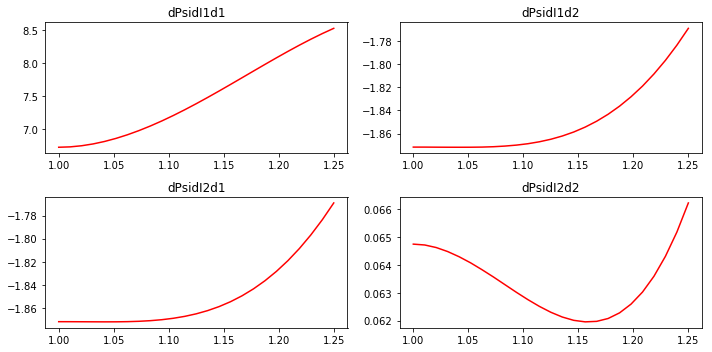

In [36]:
fig, axs = plt.subplots(2,2,figsize=(10,5))
#axs[0,0].plot(lam_eq_ls,Psi11_eb,color='black')
axs[0,0].plot(lam_eq_ls,dPsidI1dI1,color='red')
axs[0,0].set_title('dPsidI1d1')

#axs[0,1].plot(lam_eq_ls,Psi12_eb,color='black')
axs[0,1].plot(lam_eq_ls,dPsidI1dI2,color='red')
axs[0,1].set_title('dPsidI1d2')

#axs[1,0].plot(lam_eq_ls,Psi21_eb,color='black')
axs[1,0].plot(lam_eq_ls,dPsidI2dI1,color='red')
axs[1,0].set_title('dPsidI2d1')

#axs[1,1].plot(lam_eq_ls,Psi22_eb,color='black')
axs[1,1].plot(lam_eq_ls,dPsidI2dI2,color='red')
axs[1,1].set_title('dPsidI2d2')
plt.tight_layout()

In [37]:
(dPsidI2dI2*dPsidI1dI1 - dPsidI1dI2*dPsidI2dI1)

array([-3.06773012, -3.06757637, -3.06729972, -3.06667388, -3.06562124,
       -3.06400912, -3.06168734, -3.05830198, -3.05370295, -3.047668  ,
       -3.03983931, -3.02988432, -3.01755561, -3.00247625, -2.98438595,
       -2.96284257, -2.93763407, -2.90837062, -2.87470483, -2.83632026,
       -2.79308755, -2.74445509, -2.69039886, -2.63065198, -2.56497255])

In [38]:
# So, even Ogden might be non-convex? Maybe this is quite a restrictive assumption
# let's check the other assumption 
# To check the monotonicity of the stress, or the equivalent check from Vlassis, I'll do 
# it with the Psi1 and Psi2 functions from the GP, and compare that I have the correct sigma 

## Check convexity between any pair of biaxial deformations 
convexity_checks = np.zeros((121*61))
stress_error = np.zeros((121))
ct=0
neg_ct = 0
pos_ct = 0
z_ct = 0
for i in range(121):
    # generate the stress for point 'i' but based on my interpolation of Psi1 and Psi2 
    lamx_i = np.sqrt(C_vec[i,0])
    lamy_i = np.sqrt(C_vec[i,1])
    lamz_i = 1./(lamx_i*lamy_i)
    I1_i = lamx_i**2 + lamy_i**2 + lamz_i**2 
    I2_i = lamx_i**2*lamy_i**2 + lamy_i**2*lamz_i**2  + lamz_i**2*lamx_i**2 
    X_test = np.zeros((1,2))
    X_test[0,0]  = I1_i
    X_test[0,1]  = I2_i
    X_test_scaled = (X_test - X_mean) / X_std
    grad_Psi, dvar = model_O.predict_jacobian(X_test_scaled)
    dPsidI1 = grad_Psi[:,0,0]/X_std[0]
    dPsidI2 = grad_Psi[:,1,0]/X_std[1]
    # PK2 = 2*Psi1*I + 2*Psi2*(I1*I-C) + p*Cinv 
    # from the plane stress we get 
    p = -(2*dPsidI1+2*dPsidI2*(I1_i-lamz_i**2))*lamz_i**2
    C2d_i = np.array([[lamx_i**2,0],[0,lamy_i**2]])
    C2dinv_i = np.array([[1/lamx_i**2,0],[0,1/lamy_i**2]])
    PK2_i = 2*dPsidI1*np.eye(2) + 2*dPsidI2*(I1_i*np.eye(2)-C2d_i) + p*C2dinv_i
    # does this match the stress I have in the array? 
    stress_error[i] = np.sqrt((PK2_i[0,0]-PK2_vec[i,0])**2+(PK2_i[1,1]-PK2_vec[i,1])**2)
    for j in range(i+1,121): 
        # Taylor expansion 
        # Psi_j = Psi_i + dSdC_i:(C_j - C_i)
        # Previous check was done with PK2 pulled back from sigma
        # check = Psi_vec[j]- Psi_vec[i] - 0.5*np.dot(PK2_vec[i],C_vec[j]-C_vec[i])
        # Instead, I want to do it with the PK2 built up with the Psi1 and Psi2 
        # keep the energy from the data, only thing that is calculated differently from
        # the previous check is the PK2 
        check = Psi_vec[j]- Psi_vec[i] - 0.5*np.dot(np.array([PK2_i[0,0],PK2_i[1,1]]),C_vec[j]-C_vec[i])
        convexity_checks[ct] = check
        if check<0:
            neg_ct+=1
        elif check>0:
            pos_ct+=1
        elif check==0:
            z_ct+=1
        ct+=1

In [44]:
# Printing the stress and the error 
print(np.hstack([PK2_vec,stress_error.reshape(121,1)]))

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.46023701e-02 2.01174508e-01 1.39117501e-04]
 [1.69590310e-01 3.86943196e-01 2.31650139e-04]
 [2.29360703e-01 5.66041198e-01 2.86773785e-04]
 [2.77253922e-01 7.45319584e-01 3.22596638e-04]
 [3.15824023e-01 9.30336333e-01 3.97712093e-04]
 [3.47035830e-01 1.12577031e+00 5.72703313e-04]
 [3.72409742e-01 1.33571447e+00 8.10462534e-04]
 [3.93128850e-01 1.56388603e+00 1.04473621e-03]
 [4.10118713e-01 1.81377896e+00 1.51236679e-03]
 [4.24107142e-01 2.08877631e+00 3.13040001e-03]
 [2.01174508e-01 9.46023701e-02 1.39117501e-04]
 [2.74132836e-01 2.74132836e-01 1.35026115e-04]
 [3.31964313e-01 4.43562786e-01 1.44878422e-04]
 [3.78059859e-01 6.10243979e-01 1.86152791e-04]
 [4.14995606e-01 7.80025567e-01 2.27045187e-04]
 [4.44741267e-01 9.57734396e-01 2.94584741e-04]
 [4.68812136e-01 1.14751195e+00 4.48122163e-04]
 [4.88380760e-01 1.35305350e+00 6.36238219e-04]
 [5.04359551e-01 1.57777999e+00 7.28749184e-04]
 [5.17462309e-01 1.82496332e+00 9.504484

(array([3.137e+03, 1.860e+03, 1.169e+03, 7.040e+02, 3.060e+02, 1.390e+02,
        4.500e+01, 1.400e+01, 6.000e+00, 1.000e+00]),
 array([0.        , 0.06092812, 0.12185624, 0.18278437, 0.24371249,
        0.30464061, 0.36556873, 0.42649686, 0.48742498, 0.5483531 ,
        0.60928122]),
 <a list of 10 Patch objects>)

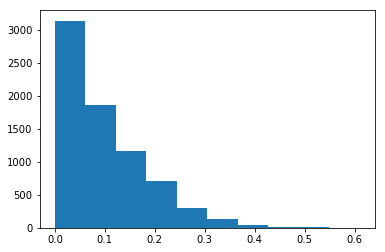

In [45]:
# So not bad, not bad 
plt.hist(convexity_checks)

In [46]:
print(pos_ct)
print(neg_ct)
print(z_ct)

7260
0
0


# Check RVE data 

We can check if the RVE data is convex even before we can try to fit it with the neural network. 
Then, as long as the NN tries to interpolate the convex function it will be convex at those points. 

In [88]:
# Load in the RVE data for just one microstructure 
# data_biaxial = pd.read_csv('biaxial_networks_optimized_dri.csv')  
data_biaxial = pd.read_csv('networks_theta_0.3_scaled_optimized_dri.csv')

In [89]:
data_biaxial

seeds  cube_length  fiber_diameter  percent_volume_fraction  \
0        250         21.7             0.1                 0.307002   
1        250         21.7             0.1                 0.307002   
2        250         21.7             0.1                 0.307002   
3        250         21.7             0.1                 0.307002   
4        250         21.7             0.1                 0.307002   
...      ...          ...             ...                      ...   
12095    400         27.0             0.1                 0.302023   
12096    400         27.0             0.1                 0.302023   
12097    400         27.0             0.1                 0.302023   
12098    400         27.0             0.1                 0.302023   
12099    400         27.0             0.1                 0.302023   

       total_fibers  inner_nodes  percent_inner_node  lambdaX  lambdaY  \
0               367          117               0.468     1.00    1.000   
1               367          117               0.468     1.00    1.025   
2               367          117               0.468     1.00    1.050   
3               367          117               0.468     1.00    1.075   
4               367          117               0.468     1.00    1.100   
...             ...          ...                 ...      ...      ...   
12095           630          230               0.575     1.25    1.150   
12096           630          230               0.575     1.25    1.175   
12097           630          230               0.575     1.25    1.200   
12098           630          230               0.575     1.25    1.225   
12099           630          230               0.575     1.25    1.250   

        lambdaZ  ...  total_psif  psif_scaled   dPsidI1   dPsidI2  \
0      1.000000  ...    0.000000     0.000000  2.650369 -1.719587   
1      0.975610  ...    0.001004     0.002132  2.658896 -1.719058   
2      0.952381  ...    0.004021     0.008539  2.683611 -1.717499   
3      0.930233  ...    0.008876     0.018848  2.723233 -1.714920   
4      0.909091  ...    0.016228     0.034463  2.776484 -1.711300   
...         ...  ...         ...          ...       ...       ...   
12095  0.695652  ...    0.287326     0.394137  2.974325 -1.124600   
12096  0.680851  ...    0.323225     0.443381  2.990988 -1.069289   
12097  0.666667  ...    0.363697     0.498899  2.995015 -0.999460   
12098  0.653061  ...    0.410419     0.562989  2.983712 -0.915470   
12099  0.640000  ...    0.465125     0.638031  2.952660 -0.819169   

       rho_unRestrict  phi_1_unRestrict  phi_2_unRestrict  rho_Restrict  \
0            8.739912          2.650369         -1.719587      5.300738   
1            8.735580          2.657993         -1.720017      5.226819   
2            8.757983          2.681457         -1.720076      5.062091   
3            8.796194          2.718312         -1.720997      4.831238   
4            8.861334          2.774149         -1.715905      4.601087   
...               ...               ...               ...           ...   
12095        7.571676          2.976541         -1.115075      2.501702   
12096        7.439426          2.992881         -1.061260      2.397209   
12097        7.224164          2.993453         -0.996543      2.286712   
12098        6.927660          2.977523         -0.919983      2.184646   
12099        6.537577          2.945972         -0.829619      2.096588   

       phi_1_Restrict  phi_2_Restrict  
0            2.650369    6.188760e-16  
1            2.625056    1.113390e-15  
2            2.559440   -8.950410e-16  
3            2.470584    5.305670e-15  
4            2.385498    8.389430e-16  
...               ...             ...  
12095        1.865222   -1.972830e-15  
12096        1.869778    1.009760e-15  
12097        1.881131    6.032730e-16  
12098        1.901325   -7.368840e-17  
12099        1.934816   -3.623420e-16  

[12100 rows x 25 columns]

In [90]:
list(data_biaxial.columns)

['seeds',
 'cube_length',
 'fiber_diameter',
 'percent_volume_fraction',
 'total_fibers',
 'inner_nodes',
 'percent_inner_node',
 'lambdaX',
 'lambdaY',
 'lambdaZ',
 'sigmaXX',
 'sigmaYY',
 'sigmaZZ',
 'I1',
 'I2',
 'total_psif',
 'psif_scaled',
 'dPsidI1',
 'dPsidI2',
 'rho_unRestrict',
 'phi_1_unRestrict',
 'phi_2_unRestrict',
 'rho_Restrict',
 'phi_1_Restrict',
 'phi_2_Restrict']

In [258]:
# for each microstructure compute the PK2 from dPsidI1 and dPsidI2 and 
# then do the convexity check 
# how to sub-select data? 
rvei=16
ind1=121*rvei
ind2=121*(rvei+1)
lamx_vec = data_biaxial['lambdaX'][ind1:ind2].to_numpy()
lamy_vec = data_biaxial['lambdaY'][ind1:ind2].to_numpy()
Psi1_vec = data_biaxial['phi_1_unRestrict'][ind1:ind2].to_numpy()
Psi2_vec = data_biaxial['phi_2_unRestrict'][ind1:ind2].to_numpy()
#Psi1_vec = data_biaxial['dPsidI1'][ind1:ind2].to_numpy()
#Psi2_vec = data_biaxial['dPsidI2'][ind1:ind2].to_numpy()
Psi_vec = data_biaxial['psif_scaled'][ind1:ind2].to_numpy()
#
sigmax_vec = data_biaxial['sigmaXX'][ind1:ind2].to_numpy()
sigmay_vec = data_biaxial['sigmaYY'][ind1:ind2].to_numpy()

In [259]:
## Check convexity between any pair of biaxial deformations 
convexity_checks = np.zeros((121*121))
convexity_checks_rve = np.zeros((121*121))
PK2_vec = np.zeros((121,2))
PK2rve_vec = np.zeros((121,2))
stress_error = np.zeros((121,1))
ct=0
neg_ct = 0
pos_ct = 0
z_ct = 0
for i in range(121):
    # generate the stress for point 'i' but based on my interpolation of Psi1 and Psi2 
    lamx_i = lamx_vec[i]
    lamy_i = lamy_vec[i]
    lamz_i = 1./(lamx_i*lamy_i)
    I1_i = lamx_i**2 + lamy_i**2 + lamz_i**2 
    I2_i = lamx_i**2*lamy_i**2 + lamy_i**2*lamz_i**2  + lamz_i**2*lamx_i**2 
    dPsidI1 = Psi1_vec[i]
    dPsidI2 = Psi2_vec[i]
    # PK2 = 2*Psi1*I + 2*Psi2*(I1*I-C) + p*Cinv 
    # from the plane stress we get 
    p = -(2*dPsidI1+2*dPsidI2*(I1_i-lamz_i**2))*lamz_i**2
    C2d_i = np.array([[lamx_i**2,0],[0,lamy_i**2]])
    C2dinv_i = np.array([[1/lamx_i**2,0],[0,1/lamy_i**2]])
    PK2_i = 2*dPsidI1*np.eye(2) + 2*dPsidI2*(I1_i*np.eye(2)-C2d_i) + p*C2dinv_i
    # does this match the stress I have in the array? 
    PK2_vec[i,0] = PK2_i[0,0]
    PK2_vec[i,1] = PK2_i[1,1]
    # the stress from the RVE simulation directly is cauchy, transform to PK2 
    F = np.array([[lamx_i,0],[0,lamy_i]])
    Finv = np.array([[1/lamx_i,0],[0,1/lamy_i]])
    sigma = np.array([[sigmax_vec[i],0],[0,sigmay_vec[i]]])
    PK2rve = np.dot(Finv,np.dot(sigma,Finv.transpose()))
    PK2rve_vec[i,0] = PK2rve[0,0]
    PK2rve_vec[i,1] = PK2rve[1,1]
    stress_error[i] = np.sqrt((PK2_i[0,0]-PK2rve[0,0])**2+(PK2_i[1,1]-PK2rve[1,1])**2)
    C_i = np.array([lamx_vec[i]**2,lamy_vec[i]**2])
    for j in range(0,121): 
        # Taylor expansion 
        # Psi_j = Psi_i + dSdC_i:(C_j - C_i)
        # Previous check was done with PK2 pulled back from sigma
        # check = Psi_vec[j]- Psi_vec[i] - 0.5*np.dot(PK2_vec[i],C_vec[j]-C_vec[i])
        # Instead, I want to do it with the PK2 built up with the Psi1 and Psi2 
        # keep the energy from the data, only thing that is calculated differently from
        # the previous check is the PK2 
        C_j = np.array([lamx_vec[j]**2,lamy_vec[j]**2])
        check = Psi_vec[j]- Psi_vec[i] - 0.5*np.dot(np.array([PK2_i[0,0],PK2_i[1,1]]),C_j-C_i)
        convexity_checks[ct] = check
        check_rve = Psi_vec[j]- Psi_vec[i] - 0.5*np.dot(np.array([PK2rve[0,0],PK2rve[1,1]]),C_j-C_i)
        convexity_checks[ct] = check
        convexity_checks_rve[ct] = check_rve
        if check<0:
            #print('not satisfied')
            #print(C_i)
            #print(C_j)
            #print(C_j-C_i)
            #print(PK2_i)
            neg_ct+=1
        elif check>0:
            #print('satisfied')
            #print(C_j-C_i)
            pos_ct+=1
        elif check==0:
            z_ct+=1
        ct+=1

(array([5.263e+03, 4.662e+03, 2.628e+03, 1.304e+03, 4.620e+02, 1.910e+02,
        8.100e+01, 3.600e+01, 1.100e+01, 3.000e+00]),
 array([-0.02743208,  0.05317706,  0.13378621,  0.21439535,  0.29500449,
         0.37561363,  0.45622278,  0.53683192,  0.61744106,  0.69805021,
         0.77865935]),
 <a list of 10 Patch objects>)

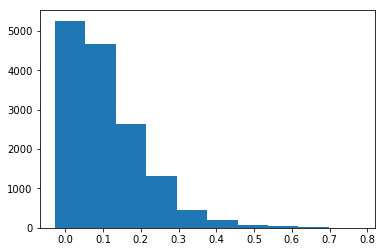

In [260]:
plt.hist(convexity_checks)

(array([4.701e+03, 4.593e+03, 2.776e+03, 1.572e+03, 6.140e+02, 2.300e+02,
        9.700e+01, 3.800e+01, 1.600e+01, 4.000e+00]),
 array([-0.02959799,  0.04788577,  0.12536953,  0.20285328,  0.28033704,
         0.3578208 ,  0.43530455,  0.51278831,  0.59027207,  0.66775583,
         0.74523958]),
 <a list of 10 Patch objects>)

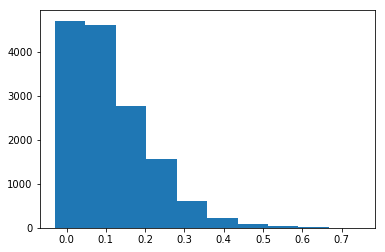

In [261]:
plt.hist(convexity_checks_rve)

In [262]:
print(pos_ct)
print(neg_ct)
print(neg_ct/(pos_ct+neg_ct)*100)

14199
321
2.2107438016528924


In [250]:
# Printing the stress and the error 
print(np.hstack([PK2_vec,PK2rve_vec,stress_error]))

[[0.         0.         0.         0.         0.        ]
 [0.07279996 0.15582363 0.01082935 0.10372192 0.08096261]
 [0.13176409 0.3037735  0.03423745 0.23269863 0.12067759]
 [0.18229201 0.45324625 0.06610574 0.38799439 0.1332556 ]
 [0.22859288 0.61092631 0.09977759 0.56100361 0.13815084]
 [0.27389626 0.78141819 0.14448052 0.73209483 0.13849631]
 [0.32060752 0.96769364 0.19120266 0.92824854 0.13528316]
 [0.37041828 1.17140244 0.23571428 1.14614947 0.13705065]
 [0.42438161 1.39308445 0.29714949 1.36698844 0.12988077]
 [0.4829604  1.63231162 0.35587482 1.59984027 0.13116834]
 [0.54605629 1.88778219 0.42470004 1.85655373 0.12530984]
 [0.15582363 0.07279996 0.09532369 0.10348795 0.067838  ]
 [0.21322947 0.21322947 0.10920995 0.1241533  0.13694752]
 [0.26232279 0.35177505 0.12994838 0.24943604 0.16732082]
 [0.30739575 0.49627605 0.17812308 0.41285563 0.15385184]
 [0.35173374 0.65220291 0.21709764 0.5877059  0.14928745]
 [0.39778468 0.82319967 0.26483567 0.76520253 0.14504864]
 [0.44727991 1

(array([ 1.,  0.,  0.,  1.,  1.,  2.,  7., 17., 47., 45.]),
 array([0.        , 0.01785734, 0.03571468, 0.05357202, 0.07142936,
        0.0892867 , 0.10714404, 0.12500139, 0.14285873, 0.16071607,
        0.17857341]),
 <a list of 10 Patch objects>)

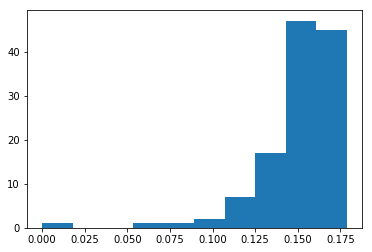

In [263]:
plt.hist(stress_error)
#plt.savefig('stress_error_optimized.png')

In [252]:
# the error is actually worsed after optimization than the original one, which is not correct 
# meaning something in the 'optimized' is not well done 
# there is one inconsistency in the energy which is that the RVE does not have plane stress, but I dont add that
# to the energy and I should. I can correct for that. That's a small error. 
# The NN should push the Psi1 and Psi2 to get convexity and that's the most important correction. 
# Different check for the convexity is the monotonicity

## Check convexity between any pair of biaxial deformations 
convexity_checks = np.zeros((121*121))
ct=0
neg_ct = 0
pos_ct = 0
z_ct = 0
for i in range(121):
    # generate the stress for point 'i' but based on my interpolation of Psi1 and Psi2 
#     lamx_i = lamx_vec[i]
#     lamy_i = lamy_vec[i]
#     lamz_i = 1./(lamx_i*lamy_i)
#     I1_i = lamx_i**2 + lamy_i**2 + lamz_i**2 
#     I2_i = lamx_i**2*lamy_i**2 + lamy_i**2*lamz_i**2  + lamz_i**2*lamx_i**2 
#     dPsidI1 = Psi1_vec[i]
#     dPsidI2 = Psi2_vec[i]
#     # PK2 = 2*Psi1*I + 2*Psi2*(I1*I-C) + p*Cinv 
#     # from the plane stress we get 
#     p = -(2*dPsidI1+2*dPsidI2*(I1_i-lamz_i**2))*lamz_i**2
#     C2d_i = np.array([[lamx_i**2,0],[0,lamy_i**2]])
#     C2dinv_i = np.array([[1/lamx_i**2,0],[0,1/lamy_i**2]])
#     PK2_i = 2*dPsidI1*np.eye(2) + 2*dPsidI2*(I1_i*np.eye(2)-C2d_i) + p*C2dinv_i
#     # does this match the stress I have in the array? 
#     PK2_vec[i,0] = PK2_i[0,0]
#     PK2_vec[i,1] = PK2_i[1,1]
    C_i = np.array([lamx_vec[i]**2,lamy_vec[i]**2])
    for j in range(0,121): 
        # Monotonicity check 
        C_j = np.array([lamx_vec[j]**2,lamy_vec[j]**2])
        check = np.dot(PK2_vec[j]-PK2_vec[i],C_j-C_i)
        convexity_checks[ct] = check
        if check<0:
            #print('not satisfied: Ci,Cj,Pk2i')
            #print(C_i)
            #print(C_j)
            #print(PK2_i)
            neg_ct+=1
        elif check>0:
            pos_ct+=1
        elif check==0:
            z_ct+=1
        ct+=1

(array([6.571e+03, 3.724e+03, 2.260e+03, 1.240e+03, 4.760e+02, 2.040e+02,
        1.000e+02, 3.800e+01, 2.200e+01, 6.000e+00]),
 array([0.        , 0.28400753, 0.56801506, 0.85202259, 1.13603012,
        1.42003765, 1.70404518, 1.98805271, 2.27206024, 2.55606778,
        2.84007531]),
 <a list of 10 Patch objects>)

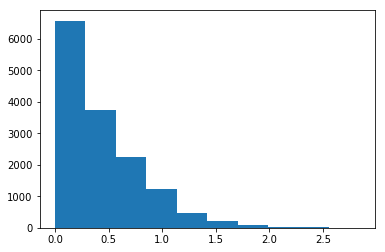

In [253]:
plt.hist(convexity_checks)

In [254]:
# let's check for all RVEs 
fraction_nonconvex_rve = np.zeros((100))
for rvei in range(100):
    ind1=121*rvei
    ind2=121*(rvei+1)
    lamx_vec = data_biaxial['lambdaX'][ind1:ind2].to_numpy()
    lamy_vec = data_biaxial['lambdaY'][ind1:ind2].to_numpy()
    Psi1_vec = data_biaxial['phi_1_unRestrict'][ind1:ind2].to_numpy()
    Psi2_vec = data_biaxial['phi_2_unRestrict'][ind1:ind2].to_numpy()
    #Psi1_vec = data_biaxial['dPsidI1'][ind1:ind2].to_numpy()
    #Psi2_vec = data_biaxial['dPsidI2'][ind1:ind2].to_numpy()
    Psi_vec = data_biaxial['psif_scaled'][ind1:ind2].to_numpy()
    #sigmax_vec = data_biaxial['sigmaXX'][ind1:ind2].to_numpy()
    #sigmay_vec = data_biaxial['sigmaYY'][ind1:ind2].to_numpy()
    convexity_checks = np.zeros((121*121))
    PK2_vec = np.zeros((121,2))
    ct=0
    neg_ct = 0
    pos_ct = 0
    z_ct = 0
    for i in range(121):
        # generate the stress for point 'i' but based on my interpolation of Psi1 and Psi2 
        lamx_i = lamx_vec[i]
        lamy_i = lamy_vec[i]
        lamz_i = 1./(lamx_i*lamy_i)
        I1_i = lamx_i**2 + lamy_i**2 + lamz_i**2 
        I2_i = lamx_i**2*lamy_i**2 + lamy_i**2*lamz_i**2  + lamz_i**2*lamx_i**2 
        dPsidI1_i = Psi1_vec[i]
        dPsidI2_i = Psi2_vec[i]
        # PK2 = 2*Psi1*I + 2*Psi2*(I1*I-C) + p*Cinv 
        # from the plane stress we get 
        p = -(2*dPsidI1_i+2*dPsidI2_i*(I1_i-lamz_i**2))*lamz_i**2
        C2d_i = np.array([[lamx_i**2,0],[0,lamy_i**2]])
        C2dinv_i = np.array([[1/lamx_i**2,0],[0,1/lamy_i**2]])
        PK2_i = 2*dPsidI1_i*np.eye(2) + 2*dPsidI2_i*(I1_i*np.eye(2)-C2d_i) + p*C2dinv_i
        # does this match the stress I have in the array? 
        PK2_vec[i,0] = PK2_i[0,0]
        PK2_vec[i,1] = PK2_i[1,1]
        C_i = np.array([lamx_vec[i]**2,lamy_vec[i]**2])
        for j in range(0,121): 
            lamx_j = lamx_vec[j]
            lamy_j = lamy_vec[j]
            lamz_j = 1./(lamx_j*lamy_j)
            I1_j = lamx_j**2 + lamy_j**2 + lamz_j**2 
            I2_j = lamx_j**2*lamy_j**2 + lamy_j**2*lamz_j**2  + lamz_j**2*lamx_j**2 
            dPsidI1_j = Psi1_vec[j]
            dPsidI2_j = Psi2_vec[j]
            # PK2 = 2*Psi1*I + 2*Psi2*(I1*I-C) + p*Cinv 
            # from the plane stress we get 
            p = -(2*dPsidI1_j+2*dPsidI2_j*(I1_j-lamz_j**2))*lamz_j**2
            C2d_j = np.array([[lamx_j**2,0],[0,lamy_j**2]])
            C2dinv_j = np.array([[1/lamx_j**2,0],[0,1/lamy_j**2]])
            PK2_j = 2*dPsidI1_j*np.eye(2) + 2*dPsidI2_j*(I1_j*np.eye(2)-C2d_j) + p*C2dinv_j
            # does this match the stress I have in the array? 
            PK2_vec[j,0] = PK2_j[0,0]
            PK2_vec[j,1] = PK2_j[1,1]
            C_j = np.array([lamx_vec[j]**2,lamy_vec[j]**2])
            # check 
            check = np.dot(PK2_vec[j]-PK2_vec[i],C_j-C_i)
            if check<0:
                #print('not satisfied: Ci,Cj,Pk2i')
                #print(C_i)
                #print(C_j)
                #print(PK2_i)
                neg_ct+=1
            elif check>0:
                pos_ct+=1
            elif check==0:
                z_ct+=1
            ct+=1
    frac = neg_ct/(neg_ct+pos_ct)*100
    fraction_nonconvex_rve[rvei] = frac
        

In [255]:
fraction_nonconvex_rve

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [273]:
# let's check for all RVEs but this time the other test
fraction_nonconvex_rve = np.zeros((100))
for rvei in range(100):
    ind1=121*rvei
    ind2=121*(rvei+1)
    lamx_vec = data_biaxial['lambdaX'][ind1:ind2].to_numpy()
    lamy_vec = data_biaxial['lambdaY'][ind1:ind2].to_numpy()
    Psi1_vec = data_biaxial['phi_1_unRestrict'][ind1:ind2].to_numpy()
    Psi2_vec = data_biaxial['phi_2_unRestrict'][ind1:ind2].to_numpy()
    #Psi1_vec = data_biaxial['dPsidI1'][ind1:ind2].to_numpy()
    #Psi2_vec = data_biaxial['dPsidI2'][ind1:ind2].to_numpy()
    Psi_vec = data_biaxial['psif_scaled'][ind1:ind2].to_numpy()
    #sigmax_vec = data_biaxial['sigmaXX'][ind1:ind2].to_numpy()
    #sigmay_vec = data_biaxial['sigmaYY'][ind1:ind2].to_numpy()
    convexity_checks = np.zeros((121*61))
    PK2_vec = np.zeros((121,2))
    ct=0
    neg_ct = 0
    pos_ct = 0
    z_ct = 0
    for i in range(121):
        # generate the stress for point 'i' but based on my interpolation of Psi1 and Psi2 
        lamx_i = lamx_vec[i]
        lamy_i = lamy_vec[i]
        lamz_i = 1./(lamx_i*lamy_i)
        I1_i = lamx_i**2 + lamy_i**2 + lamz_i**2 
        I2_i = lamx_i**2*lamy_i**2 + lamy_i**2*lamz_i**2  + lamz_i**2*lamx_i**2 
        dPsidI1_i = Psi1_vec[i]
        dPsidI2_i = Psi2_vec[i]
        # PK2 = 2*Psi1*I + 2*Psi2*(I1*I-C) + p*Cinv 
        # from the plane stress we get 
        p = -(2*dPsidI1_i+2*dPsidI2_i*(I1_i-lamz_i**2))*lamz_i**2
        #p = -(dPsidI1_i+dPsidI2_i*(I1_i-lamz_i**2))*lamz_i**2
        C2d_i = np.array([[lamx_i**2,0],[0,lamy_i**2]])
        C2dinv_i = np.array([[1/lamx_i**2,0],[0,1/lamy_i**2]])
        PK2_i = 2*dPsidI1_i*np.eye(2) + 2*dPsidI2_i*(I1_i*np.eye(2)-C2d_i) + p*C2dinv_i
        #PK2_i = dPsidI1_i*np.eye(2) + dPsidI2_i*(I1_i*np.eye(2)-C2d_i) + p*C2dinv_i
        # does this match the stress I have in the array? 
        PK2_vec[i,0] = PK2_i[0,0]
        PK2_vec[i,1] = PK2_i[1,1]
        C_i = np.array([lamx_vec[i]**2,lamy_vec[i]**2])
        for j in range(0,121): 
            lamx_j = lamx_vec[j]
            lamy_j = lamy_vec[j]
            lamz_j = 1./(lamx_j*lamy_j)
            I1_j = lamx_j**2 + lamy_j**2 + lamz_j**2 
            I2_j = lamx_j**2*lamy_j**2 + lamy_j**2*lamz_j**2  + lamz_j**2*lamx_j**2 
            dPsidI1_j = Psi1_vec[j]
            dPsidI2_j = Psi2_vec[j]
            # PK2 = 2*Psi1*I + 2*Psi2*(I1*I-C) + p*Cinv 
            # from the plane stress we get 
            p = -(2*dPsidI1_j+2*dPsidI2_j*(I1_j-lamz_j**2))*lamz_j**2
            #p = -(dPsidI1_j+dPsidI2_j*(I1_j-lamz_j**2))*lamz_j**2
            C2d_j = np.array([[lamx_j**2,0],[0,lamy_j**2]])
            C2dinv_j = np.array([[1/lamx_j**2,0],[0,1/lamy_j**2]])
            PK2_j = 2*dPsidI1_j*np.eye(2) + 2*dPsidI2_j*(I1_j*np.eye(2)-C2d_j) + p*C2dinv_j
            #PK2_j = dPsidI1_j*np.eye(2) + dPsidI2_j*(I1_j*np.eye(2)-C2d_j) + p*C2dinv_j
            # does this match the stress I have in the array? 
            PK2_vec[j,0] = PK2_j[0,0]
            PK2_vec[j,1] = PK2_j[1,1]
            C_j = np.array([lamx_vec[j]**2,lamy_vec[j]**2])
            # check 
            #check = np.dot(PK2_vec[j]-PK2_vec[i],C_j-C_i)
            check = Psi_vec[j]- Psi_vec[i] - 0.5*np.dot(np.array([PK2_i[0,0],PK2_i[1,1]]),C_j-C_i)
            if check<0:
                #print('not satisfied: Ci,Cj,Pk2i')
                #print(C_i)
                #print(C_j)
                #print(PK2_i)
                neg_ct+=1
            elif check>0:
                pos_ct+=1
            elif check==0:
                z_ct+=1
            ct+=1
    frac = neg_ct/(neg_ct+pos_ct)*100
    fraction_nonconvex_rve[rvei] = frac

In [274]:
print(fraction_nonconvex_rve.mean())
fraction_nonconvex_rve

3.8286501377410462


array([ 1.38429752,  2.87878788,  1.7768595 ,  2.45179063,  6.50137741,
        2.4862259 ,  4.22176309,  2.09366391,  2.75482094,  4.4077135 ,
        5.49586777,  3.6707989 ,  3.44352617,  3.69146006,  6.11570248,
        4.05647383,  2.2107438 ,  4.35950413,  4.57300275,  3.71900826,
        4.04269972,  3.17493113,  4.06336088,  2.44490358,  1.43250689,
        2.87190083,  0.70936639,  2.96143251,  4.20798898,  3.35399449,
        3.38842975,  7.16253444,  3.59504132, 10.51652893,  6.28787879,
        3.51928375,  6.29476584,  3.13360882,  3.37465565,  4.77961433,
        4.00137741,  2.52066116, 10.26859504,  3.42286501,  3.12672176,
        2.69283747,  2.32093664,  2.30027548,  2.10743802,  2.13498623,
        3.33333333,  2.74104683,  2.3415978 ,  6.29476584,  1.35674931,
        4.49724518,  9.64876033,  2.6446281 ,  4.44903581,  4.83471074,
        1.26721763,  1.72865014,  1.06060606,  0.68181818,  5.47520661,
        2.60330579,  3.63636364,  3.815427  ,  1.51515152,  7.68

(array([11., 22., 28., 20.,  5.,  7.,  3.,  0.,  2.,  2.]),
 array([ 0.68181818,  1.75619835,  2.83057851,  3.90495868,  4.97933884,
         6.05371901,  7.12809917,  8.20247934,  9.2768595 , 10.35123967,
        11.42561983]),
 <a list of 10 Patch objects>)

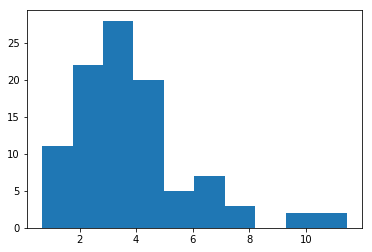

In [275]:
plt.hist(fraction_nonconvex_rve)